# Inversion d'Occam

Avec cet exemple, on va examiner comment l'inversion d'Occam peut être utile pour estimer la distribution verticale de la conductivité électrique de la proche surface.  Les mesures utilisées ont été acquises avec un conductivimètre à induction EM38 de la compagnie Geonics, illustré ci-dessous.  Cette appareil est constitué d'une bobine émettrice et d'une bobine réceptrice, séparées d'un mètre.

![alt text](EM38.jpg)

En effectuant les mesures à des hauteurs croissantes, on se trouve à accroître le volume de sol investigué et ainsi accroître la profondeur d'investigation.  Par ailleurs, on change également la profondeur d'investigation en changeant l'orientation des bobines, une polarisation horizontale étant plus sensible aux horizons superficiels.  Le levé consiste ainsi en 18 mesures, acquises à 9 hauteurs différentes pour des bobines orientées verticalement et horizontalement.  

| Hauteur (cm) | EMV (mS/m) | EMH (mS/m) |
|--------------|------------|------------|
|        0     |   134.5    |   117.4    |
|       10     |   129.0    |    97.7    |
|       20     |   120.5    |    81.7    |
|       30     |   110.5    |    69.2    |
|       40     |   100.5    |    59.6    |
|       50     |    90.8    |    51.8    |
|       75     |    70.9    |    38.2    |
|      100     |    56.8    |    29.8    |
|      150     |    38.5    |    19.9    |

La modélisation de la réponse du EM38 fait appel à une fonction où l'admittance des couches doit être calculée de façon récursive (Hendrickx et al., 2002), et des expressions analytiques ne sont pas disponibles pour calculer la jacobienne.  

Le module ```em``` contient deux classes permettant de calcul la réponse pour un sol stratifié.  Une méthode pour calculer la jacobienne par différences finies est aussi incluse.

### Référence

Hendrickx, J.M.H. and Borchers, B. and Corwin, D. L. and Lesch, S. M. and Hilgendorf, A. C. and Schlue, J., 2002.  *Inversion of Soil Conductivity Profiles from Electromagnetic Induction Measurements: Theory and Experimental Verification*.  Soil Sci. Soc. Am. J. 66:673–685.  doi: 10.2136/sssaj2002.0673

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from geo1302 import em

np.random.seed(2021)  # pour la répétabilité

help(em)

Help on module geo1302.em in geo1302:

NAME
    geo1302.em - Codes de modélisation EM.

DESCRIPTION
    Ces codes sont une adaptation des codes matlab disponibles à
    
    https://github.com/brianborchers/PEIP
    
    Created on Mon Apr  8 19:11:11 2019
    
    @author: giroux

CLASSES
    builtins.object
        EM38
        Ground
    
    class EM38(builtins.object)
     |  EM38(h, ground, f=14600.0, r=1.0)
     |  
     |  Classe pour modéliser la réponse d'un conductivimètre EM-38.
     |  
     |  Paramètres
     |  ----------
     |  h : array numpy
     |      hauteurs des mesures (m)
     |  ground : object Ground
     |      description du sol
     |  f : float
     |      Fréquence d'opération (Hz)
     |  r : float
     |      distance entre les bobines
     |  
     |  Methods defined here:
     |  
     |  G(self, sigma)
     |      Modèle direct.
     |      
     |      Paramètres
     |      ----------
     |      sigma : array numpy
     |          conductivité de

On créé d'abord un modèle de sol comportant 11 couches de 20 cm chacune (paramètres par défaut de la classe ```Ground```).  On défini ensuite un vecteur contenant les hauteurs de mesure pour pouvoir initialiser un object ```EM38```.

In [2]:
hauteurs = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0, 1.50])

sol = em.Ground()
em38 = em.EM38(hauteurs, sol)

La conductivité du modèle est représentative d'un sol sec en surface (conductivité faible), suivi d'une zone vadoze où la conductivité augmente graduellement.

On peut maintenant générer des données, auxquelles on ajoute un bruit gaussien.

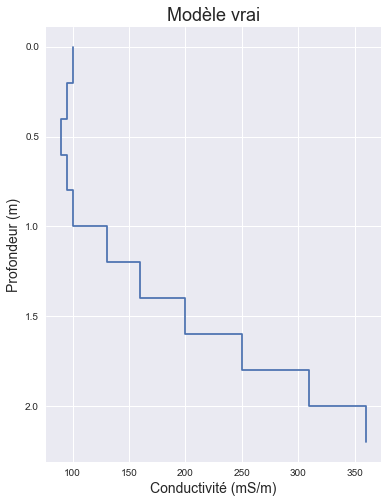

In [3]:
mtrue = np.array([100, 95, 90, 95, 100, 130, 160, 200, 250, 310, 360])/1000.0

datanf = em38.G(mtrue)
data = datanf + 0.1*np.random.randn(datanf.size)

sol.plot(mtrue)
plt.title('Modèle vrai', fontsize=18)
plt.show()

À ce stade, on peut examiner le temps requis pour calculer la réponse.

In [4]:
import time

t0 = time.time()
datanf = em38.G(mtrue)
t_em = time.time() - t0
print(t_em, 'secondes')

0.5673489570617676 secondes


Ce temps ne semble pas excessif, mais la méthode ``G`` est appelée très fréquememt pour calculer la matrice jacobienne, et il pourrait être avantageux d'avoir une méthode plus rapide.  De fait, une autre version du code a été programmée en utilisant [cython].  Cython est un language pour créer des extensions en C qui peuvent être utilisées directement dans python.  Il est en particulier possible d'inclure des objets ``numpy`` en cython.  Vous êtes invités à examiner le fichier ``em_c.pyx`` dans le répertoire ``geo1302``et à le comparer avec le code python original (fichier ``em.py``).

Voyons ce que la version cython donne.

[cython]: https://cython.readthedocs.io/en/latest/

In [5]:
from geo1302 import em_c

em38_c = em_c.EM38(hauteurs, sol)
t0 = time.time()
datanf = em38_c.G(mtrue)
t_em_c = time.time() - t0
print(t_em_c, 'secondes, donc', t_em/t_em_c, 'fois plus rapide')

0.12567400932312012 secondes, donc 4.514449408573082 fois plus rapide


Le gain n'est pas négligeable...  La version cython sera donc utilisée.

Examinons maintenant la solution obtenue avec la méthode de Marquardt-Levenberg, qui ne comporte pas de terme de régularisation.

In [6]:
def lm(G, jac, d, p0, maxit=50, tol=1.e-8):
    """
    algorithme de Levenberg-Marquardt (adapté des codes Matlab de B. Borchers)
    
    https://github.com/brianborchers/PEIP/blob/master/Examples/chap10/ex_10_2/lm.m
    
    Paramètres
    ----------
    G : fonction G(m)
        fonction calculant le modèle direct
    jac : fonction jac(m)
        fonction calculant la jacobienne
    d : array numpy
        données
    p0 : array numpy
        modèle initial
    maxit : int
        nombre maximal d'itération
    tol : float
        critère d'arrêt
        
    Retourne
    --------
    p : array numpy
        modèle estimé
    """
    p = m0.copy()
    fp = np.linalg.norm(G(p) - d)
    oldp = p0*2
    oldfp = fp*2
    
    lmbda = 0.0001
    iteration = 1
    maxiteration = maxit
    while iteration < maxiteration:
        J = jac(p)
        # Compute rhs=-J'*f
        #
        #    rhs=-J'*feval(func,p);
        #
        # We use a clever trick here.  The least squares problem
        #
        #  min || [ J              ] s - [ -F ] ||
        #      || [ sqrt(lambda)*I ]     [ 0  ] ||
        #
        # Has the normal equations solution
        #
        #  s=-inv(J'*J+lambda*I)*J'*F
        #
        # which is precisely the LM step.  We can solve this least squares problem
        # more accurately using the QR factorization than by computing 
        # inv(J'*J+lambda*I) explicitly,
        rhs = -J.T @ (G(p) - d)
        
        if ((np.linalg.norm(rhs) < np.sqrt(tol)*(1+np.abs(fp))) and
            (np.abs(oldfp-fp) < tol*(1+np.abs(fp))) and
            (np.linalg.norm(oldp-p) < np.sqrt(tol)*(1+np.linalg.norm(p)))):
            return p

        myrhs = np.r_[-(G(p) - d), np.zeros((len(p), ))]
        
        # least-squares
        # t0 = time.time()
        sol = np.linalg.lstsq(np.r_[J, np.sqrt(lmbda)*np.eye(len(p))], myrhs,
                              rcond=None)
        s = sol[0]
        # print('lstsq', time.time()-t0)
        # QR
        #    les tests montrent que c'est ~2 fois plus lent... 
        # t0 = time.time()
        # q, r = np.linalg.qr(np.r_[J, np.sqrt(lmbda)*np.eye(len(p))])
        # myrhs = q.T @ myrhs
        # s = np.dot(np.linalg.inv(r), myrhs)
        # print('QR', time.time()-t0)
        
        # See whether this improves chisq or not.

        fpnew = np.linalg.norm(G(p+s) - d)**2
        
        # If this improves f, then make the step, and decrease lambda and make
        # the step.
        if fpnew < fp:
            oldp = p.copy()
            oldfp = fp.copy()
            p += s
            fp = fpnew.copy()
            lmbda = lmbda/2
            if (lmbda < 1.0e-12):
                lmbda = 1.0e-12
        else:
            # Didn't improve f, increase lambda, and try again
            lmbda = lmbda*2.5
            if (lmbda > 1.0e16):
                lmbda = 1.0e16
        iteration += 1
    return p

# Utilisation de la fonction

m0 = 200.0/1000.0 + np.zeros(mtrue.shape)

t0 = time.time()
mlm = lm(em38_c.G, em38_c.jac, data, m0, 50, 1.e-6)
t_lm = time.time() - t0

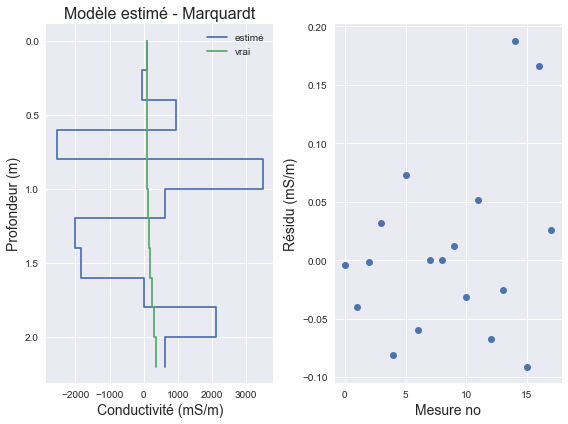

In [7]:
plt.figure(figsize=(8,6))
ax1 = plt.subplot(121)
sol.plot(mlm, ax1, label='estimé')
sol.plot(mtrue, ax1, label='vrai')
ax1.legend()
plt.title('Modèle estimé - Marquardt', fontsize=16)
plt.subplot(122)
plt.plot(em38_c.G(mlm)-data, 'o')
plt.xlabel('Mesure no', fontsize=14)
plt.ylabel('Résidu (mS/m)', fontsize=14)
plt.tight_layout()
plt.show()

On peut remarquer des valeurs totalement irréalistes et des variations très brusques dans le modèle, ce qui ne correspond pas au résultat attendu.  La raison est que **J**^T**J** est très mal conditionnée.

In [8]:
J = em38_c.jac(mtrue)
np.linalg.cond(J.T @ J)

4.547764380559004e+17

Voyons maintenant l'inversion d'Occam.

In [9]:
def get_D(n, deg):
    """Matrice de lissage.
    """
    if deg == 0:
        return np.eye(n)
    
    df = np.hstack((np.array([-1, 1]), np.zeros((deg-1,))))
    for i in range(1, deg):
        # take the difference of the lower order derivative and itself shifted left 
        # to get a derivative one order higher
        df = np.hstack((np.zeros((1,)), df[:deg])) - np.hstack((df[:deg], np.zeros((1,))))

    dn  = n - deg
    D = np.zeros((dn, n))
    for d in range(deg+1):
        for i in range(dn):
            j = i+d
            D[i, j] = df[d]
    return D
    

def occam(G, jac, D, d, m0, delta):
    """
    Inversion d'Occam (adapté des codes Matlab de B. Borchers)
    
    https://github.com/brianborchers/PEIP/blob/master/Lib/occam.m
    
    Paramètres
    ----------
    G : fonction G(m)
        fonction calculant le modèle direct
    jac : fonction jac(m)
        fonction calculant la jacobienne
    d : array numpy
        données
    m0 : array numpy
        modèle initial
    delta : float
        seuil d'application du principe de divergence (discrepancy)
        
    Retourne
    --------
    m : array numpy
        modèle estimé
    """
    
    m = m0.copy()
    oldm = np.zeros(m.shape)
    it = 0
    
    DTD = D.T.dot(D)
    
    Gm = G(m)
    mchi2 = np.linalg.norm(Gm - d)**2
    
    # recherche "force brute" du alpha optimal
    alphas = np.logspace(-20, 0, 100)
    chis = np.empty((alphas.size,))

    while (np.linalg.norm(oldm-m)/np.linalg.norm(m) > 5.0e-3) or (mchi2 > delta*delta*1.01):
        it += 1
        if it > 30:
            return m
        
        oldm = m.copy()
        
        J = jac(m)
        
        dhat = d - Gm + J.dot(m)
                
        for i in range(alphas.size):
            M = J.T.dot(J) + alphas[i]**2*DTD
            if np.linalg.cond(M) < 1.e15:
                
                m = np.linalg.solve(M, J.T.dot(dhat))
                
                chis[i] = np.linalg.norm(G(m) - d)**2
            else:
                chis[i] = np.inf
                
        y = chis.min()
        if y > delta*delta:
            i = np.argmin(chis)
            alpha = alphas[i]
        else:
            i = np.where(chis<=delta*delta)
            alpha = alphas[np.max(i)]
            
        m = np.linalg.solve(J.T.dot(J) + alpha**2*DTD, J.T.dot(dhat))
        Gm = G(m)
        mchi2 = np.linalg.norm(Gm - d)**2
        
    return m


# Utilisation de la fonction

D = get_D(mtrue.size, 2)
delta = 0.1 * np.sqrt(18)
t0 = time.time()
moccam = occam(em38_c.G, em38_c.jac, D, data, m0, delta)
t_occam = time.time() - t0

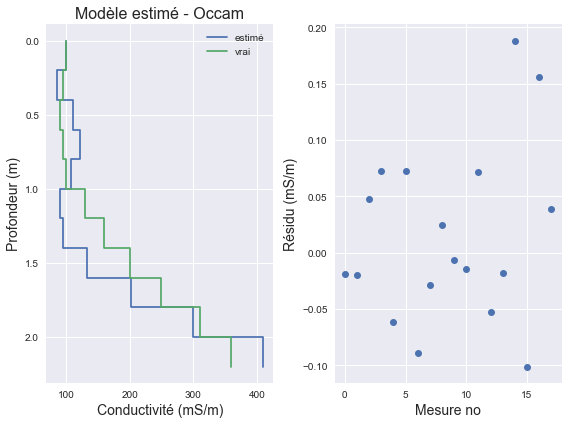

In [10]:
plt.figure(figsize=(8,6))
ax1 = plt.subplot(121)
sol.plot(moccam, ax1, label='estimé')
sol.plot(mtrue, ax1, label='vrai')
plt.legend()
plt.title('Modèle estimé - Occam', fontsize=16)
plt.subplot(122)
plt.plot(em38_c.G(moccam)-data, 'o')
plt.xlabel('Mesure no', fontsize=14)
plt.ylabel('Résidu (mS/m)', fontsize=14)
plt.tight_layout()
plt.show()

L'algorithme d'Occam donne un résultat beaucoup plus réaliste et satisfaisant.  Le temps de calcul est aussi avantageux.

In [11]:
print(t_lm, t_occam)

87.83552289009094 18.549752950668335
